# Predicting if a Blood Donor will donate within a given time window

While working for Rotaract Club of MSIT from last 3 years one of my main responsibility was to organise Blood Donation Camps, and it is an amazing event to organise because it gives you a feeling that you are helping for a right cause which saves life.

### Problem
One of the major problem while organising the Blood Donation Camp was that to convince the people who were walking near the camp to be a donor which results in 70% of the people were not interesting in donating due to reasons like they have work to do, they need to go somewhere etc.
There's this one time in every year when we organise a blood donation camp in Adarsh Public School, New Delhi on the day of parent teacher meeting, so parents were already told about the donation camp and almost 80-90% of the parents become donors. 

So, I thought that if before organising the event we could we could reach out to the right people before the donation then we will get more donors and can save more lives. As part of making records we were collecting data of the volunteers from last 2 years and contains details of there address but it was not well organised.

So I googled it.

I found the data that I needed from [Drivendata](https://www.drivendata.org/competitions/2/warm-up-predict-blood-donations/data/).

### Use information about each donor's history
- Months since Last Donation: this is the number of monthis since this donor's most recent donation.
- Number of Donations: this is the total number of donations that the donor has made.
- Total Volume Donated: this is the total amound of blood that the donor has donated in cubuc centimeters.
- Months since First Donation: this is the number of months since the donor's first donation.

# Loading the Data

The data are pre-split into training and test sets, so we’ll read them in separately. 

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv', index_col=False)
df.columns = ['id','months_since_last_donation','num_donations','vol_donations','months_since_first_donation', 'class']
test = pd.read_csv("test.csv")
test.columns = ['id','months_since_last_donation','num_donations','vol_donations','months_since_first_donation']
IDtest = test["id"]
print(df.shape)
print(df.isnull().sum())
df.head(5)

(576, 6)
id                             0
months_since_last_donation     0
num_donations                  0
vol_donations                  0
months_since_first_donation    0
class                          0
dtype: int64


,id,months_since_last_donation,num_donations,vol_donations,months_since_first_donation,class
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


The good thing is we have no missing values and we have 576 rows and 6 Columns. The features are 'Months since Last Donation', 'Number of Donations', 'Total Volume Donated', 'Months since First Donation'.

In the class column there are two classes
- class 1 : The donor donated blood in March 2007.
- class 0 : The donor did not donate blood in March 2007.

Note : I am asuming that 1 means donated and 0 means not donated

# Outliers Detection
Since outliers can have a dramatic effect on the prediction (espacially for regression problems), i choosed to manage them.

The Tukey method (Tukey JW., 1977) is used to detect ouliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values (IQR). An outlier is a row that have a feature value outside the (IQR +- an outlier step).

Detected the outliers from the numerical values features (Age, SibSp, Sarch and Fare). Then, considered outliers as rows that have at least two outlied numerical values.

In [3]:
# import required libraries
from collections import Counter

# Outlier detection 
def detect_outliers(df,n,features):
    """
    Takes a dataframe of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(df,2,["months_since_last_donation","num_donations","vol_donations","months_since_first_donation"])

In [4]:
#Outliers in train
df.loc[Outliers_to_drop]

,id,months_since_last_donation,num_donations,vol_donations,months_since_first_donation,class


This is good we have no outliers issue in the data

# Joining Train and Test Data
Join train and test datasets in order to obtain the same number of features during categorical conversion. This will help in feature engineering

In [5]:
train_len = len(df)
dataset =  pd.concat(objs=[df, test], axis=0).reset_index(drop=True)
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)
# Check for Null values
dataset.isnull().sum()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


class                          200
id                               0
months_since_first_donation      0
months_since_last_donation       0
num_donations                    0
vol_donations                    0
dtype: int64

In [6]:
dataset.head()

,class,id,months_since_first_donation,months_since_last_donation,num_donations,vol_donations
0,1.0,619,98,2,50,12500
1,1.0,664,28,0,13,3250
2,1.0,441,35,1,16,4000
3,1.0,160,45,2,20,5000
4,0.0,358,77,1,24,6000


# Feature analysis

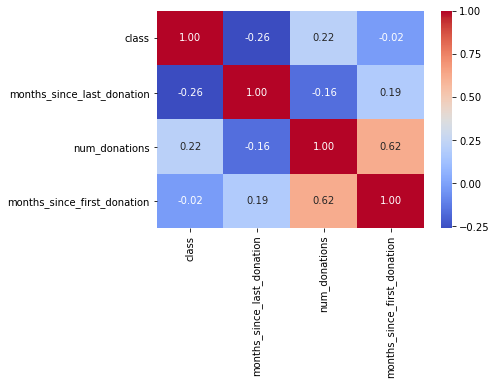

In [7]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(df[["class","months_since_last_donation","num_donations","months_since_first_donation"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

Only months_since_first_donation seems to have a significative correlation with the class probability.

It doesn't mean that the other features are not usefull. num_donations in these features can be correlated with the class. To determine this, we need to explore in detail these features.

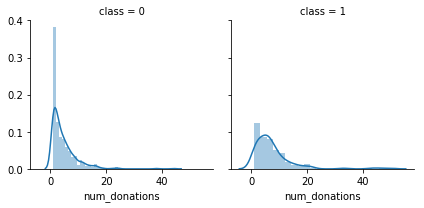

In [8]:
g = sns.FacetGrid(df, col='class')
g = g.map(sns.distplot, "num_donations")

We notice that num_donations distributions are not the same in the class 1 and class 0 subpopulations. Indeed, there is a peak corresponding to the people who have donated only 0-1 time will not donate blood and who have donated 2-3 will likely donate.

It seems that people have donated more number of times are more likely to donate blood.

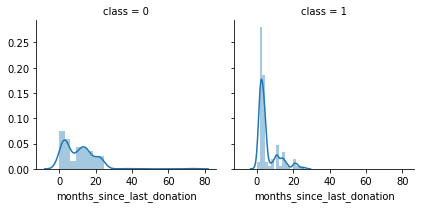

In [9]:
g = sns.FacetGrid(df, col='class')
g = g.map(sns.distplot, "months_since_last_donation")

We notice that months_since_last_donation distributions are not the same in the class 1 and class 0 subpopulations. Indeed, there is a peak corresponding to the people who have donated recently(in 1-2 months) will donate blood.

It seems that people have donated recently are more likely to donate blood.

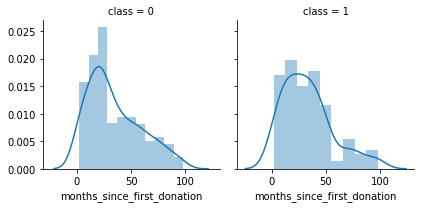

In [10]:
g = sns.FacetGrid(df, col='class')
g = g.map(sns.distplot, "months_since_first_donation")

We notice that months_since_first_donation distributions are not the same in the class 1 and class 0 subpopulations. Indeed, there is a peak corresponding to the people who have just donated recently(in 6-20 months) will not donate blood.

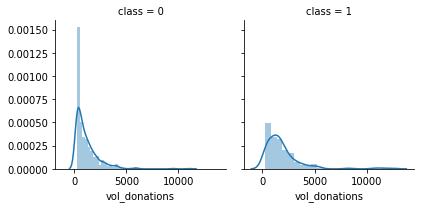

In [11]:
g = sns.FacetGrid(df, col='class')
g = g.map(sns.distplot, "vol_donations")

Volume donated is also a good feature to know wether the donor will donate or not.

### Correlation between frequency and monetary

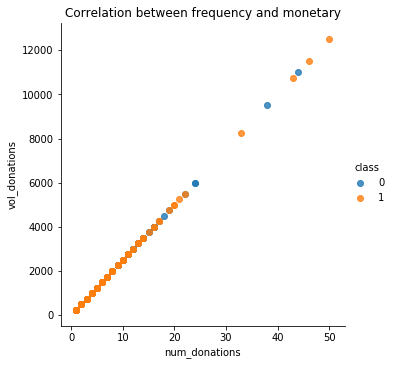

In [12]:
plt.figure(figsize=(15,10));
_ = sns.lmplot(x='num_donations',
               y='vol_donations',
               hue='class',
               fit_reg=False,
               data=df);
_ = plt.title("Correlation between frequency and monetary");
plt.show();

From the graph we can see that Frequency and monetary values are highly correlated. So we can use only the frequency.

In [13]:
# We do not require the volume column, so drop it.
dataset.drop(['id', 'vol_donations'], axis=1, inplace=True)

# Feature ENginerring

We will create a New variable = log(“Months since First Donation”-“Months since Last Donation”)

In [14]:
dataset["new_variable"] = (dataset["months_since_first_donation"] - dataset["months_since_last_donation"])

# Modeling

In [15]:
## Separate train dataset and test dataset
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["class"],axis = 1,inplace=True)

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [16]:
## Separate train features and label 

train["class"] = train["class"].astype(int)

Y_train = train["class"]

X_train = train.drop(labels = ["class"],axis = 1)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)

### Cross Validation Models
I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.

- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perceprton (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis

In [19]:
# Import the packages
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

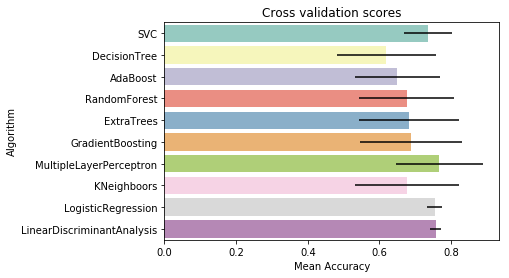

In [20]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)
# Modeling step Test differents algorithms 
random_state = 7
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train_scaled, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

By seeing the figure we can see that Random Forest, Extra Trees, Gradient Boosting Classifiers will work the best.

#### Hyperparameter tunning for best models
I performed a grid search optimization for Random Forest, Extra Trees, Gradient Boosting, SVC classifiers.
I set the "n_jobs" parameter to 4 since i have 4 cpu . The computation time is clearly reduced.

In [21]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [80, 90, 100, 110],
              "max_features": [2, 3],
              "min_samples_split": [8, 10, 12],
              "min_samples_leaf": [3, 4, 5],
              "bootstrap": [False],
              "n_estimators" :[100, 200, 300, 1000],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train_scaled,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   25.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  8.4min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 11.8min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 16.0min
[Parallel(n_jobs=4)]: Done 2880 out of 2880 | elapsed: 18.9min finished


0.7204861111111112

In [22]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [2, 3],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100, 200, 300, 1000],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train_scaled,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  4.0min finished


0.7604166666666666

In [23]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train_scaled,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   24.4s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   35.9s finished


0.7829861111111112

In [24]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train_scaled,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  47 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 273 out of 280 | elapsed:   23.3s remaining:    0.5s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   25.1s finished


0.765625

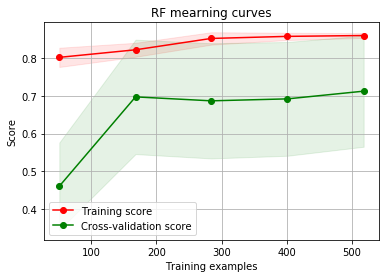

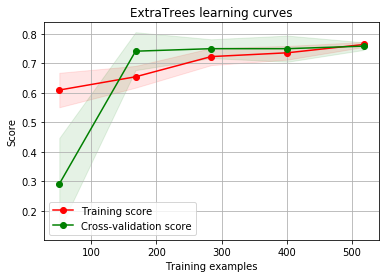

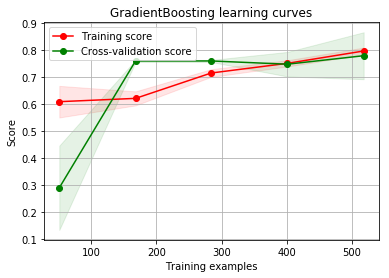

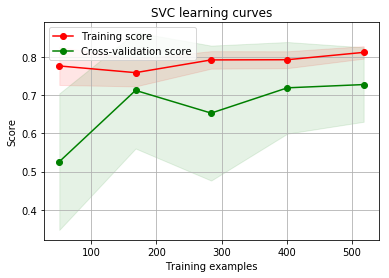

In [25]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)

 By looking at the learning curve GradientBoosting and ExtraTrees classifiers tend to overfit the training set. According to the growing cross-validation curves Random Forest classifier and SVC seems to better generalize the prediction since the training and cross-validation curves are close together.

# Testing the models on test set

So the we will use SVC classifier as a final model.

In [39]:
# Scaling the test data
test_scaled = sc.transform(test)
# predicting the results
predictions = gsSVMC.predict_proba(test_scaled)
predictions = predictions[:,1]
pred_report = pd.DataFrame(predictions.tolist(),index=IDtest,columns=["Made Donation in March 2007"])

In [41]:
# saving the prediction
pred_report.to_csv("final_submission.csv")

# Conclusion

Now we can target the people who are interested in donating blood and which will results in getting more volunteers and we can save more people.

For those interested, the Jupyter Notebook with all the code can be found in the [Github repository](https://github.com/souvikb07/Predict-Blood-Donations) for this post.